In [1]:
# Imports
from __future__ import print_function
import openeye.oechem as oechem
import openeye.oedepict as oedepict
from IPython.display import display, HTML, Image
% matplotlib inline
import time
import IPython
import pickle
import glob
import oenotebook as oenb
import pandas as pd

# Relevant methods

In [2]:
def make_molecule(smiles):
    """
    Returns an OEMol with explicit hydrogens for the SMILES provided
    """
    mol = oechem.OEMol()
    oechem.OESmilesToMol(mol, smiles)
    oechem.OEAddExplicitHydrogens(mol)
    return mol

In [3]:
def get_indice_matches(mol, smirks = '[*;a:1]'):
    oechem.OEClearAromaticFlags( mol)
    oechem.OEAssignAromaticFlags( mol, oechem.OEAroModel_MDL)
    ss = oechem.OESubSearch(smirks)
    matches = set()
    for match in ss.Match( mol, False):
        # Compile list of atom indices that match the pattern tags
        for ma in match.GetAtoms():
            if ma.pattern.GetMapIdx() != 0:
                matches.add(ma.target.GetIdx())
    return list(matches)

In [4]:
def get_atom_bond_set(mol_copy, MDL=True):
    mol = oechem.OEMol(mol_copy)
    if MDL:
        oechem.OEClearAromaticFlags( mol)
        oechem.OEAssignAromaticFlags( mol, oechem.OEAroModel_MDL)
    
    atomBondSet = oechem.OEAtomBondSet()
    for atom in mol.GetAtoms():
        if atom.IsAromatic():
            atomBondSet.AddAtom(atom)
        #print(atom, atom.IsAromatic())
    for bond in mol.GetBonds():
        if bond.IsAromatic():
            atomBondSet.AddBond(bond)
        #print(bond, bond.IsAromatic())
    
    return mol, atomBondSet

def get_aromatic_img(mol_copy, width=400., height=400., MDL=True):
    mol, atomBondSet = get_atom_bond_set(mol_copy, MDL)
    
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetSuppressHydrogens(True)
    oedepict.OEPrepareDepiction(mol, dopt)
    
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    
    disp = oedepict.OE2DMolDisplay(mol, opts)
    if not atomBondSet.IsEmpty():
        aroStyle = oedepict.OEHighlightStyle_Color
        aroColor = oechem.OEColor(oechem.OEGrey)
        oedepict.OEAddHighlighting(disp, aroColor, aroStyle, 
                                   oechem.OEIsAromaticAtom(), oechem.OEIsAromaticBond() )
        hstyle = oedepict.OEHighlightStyle_BallAndStick
        if MDL:
            hcolor = oechem.OEColor(oechem.OELightGreen)
        else:
            hcolor = oechem.OEColor(oechem.OELightBlue)
        oedepict.OEAddHighlighting(disp, hcolor, hstyle, atomBondSet)

    img = oedepict.OEImage(width, height)
    oedepict.OERenderMolecule(img, disp)
    return img

def depict_aromatics(mol_copy, width=400., height=400., MDL=True):
    img = get_aromatic_img(mol_copy, width, height, MDL)
    return oenb.draw_oeimage_to_img_tag(img)

# Visualize aromaticity in 1 molecule

In this section we show how to visualize a single molecule where the aromatic bonds are highlighted. 
To try a different molecule just change the `smiles` variable.
If you want to see OpenEye's default aromaticity model change the MDL variable to `False`.

In [5]:
smiles = "C1=CC=CC2C(=C)C3=CC=CC=C3C(=C)C1=2"
mol = oechem.OEMol()
oechem.OESmilesToMol(mol, smiles)
img = get_aromatic_img(mol, MDL=True)

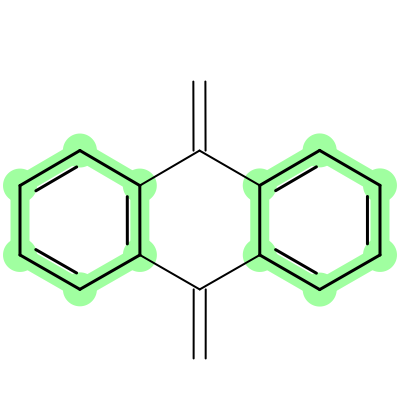

In [6]:
Image(oedepict.OEWriteImageToString("png",img))

# Visualize multiple molecules

In this section we take advantage of the `oenotebook` classes to visualize a whole list of molecules.
We do this for a series of categories

In [7]:
def make_dataframe_from_smiles(smiles):
    """
    Creates a pandas dataframe with a molecules column from a list of smiles strings
    
    Parameters
    ----------
    smiles: list of strings
        list of smiles for the molecules you want to visualize. 
    
    Returns
    -------
    df: pandas dataframe
        dataframe with a row for each SMILES string in smiles and a molecule with the MDL aromaticity model
    """
    df = pd.DataFrame()
    df['smiles'] = smiles
    df['Molecule'] = df['smiles'].apply(make_molecule)
    df['is_aromatic'] = df['Molecule'].apply(lambda x: not get_atom_bond_set(x)[1].IsEmpty())
    return df

Starting with systems a chemist might think of as aromatic, but we were pretty sure the OE MDL aromaticity model would not type as aromatic

,smiles,Molecule,is_aromatic
0,C1=C[N]C=C1,,False
1,O=C1C=CNC=C1,,False
2,C1=CS(=O)C=C1,,False
3,C1#CC=CC=C1,,False
4,C1=COC=C1,,False
5,C1=CSC=C1,,False
6,C1=CNC=C1,,False
7,C1=COC=N1,,False
8,C1=CSC=N1,,False
9,C1=CNC=N1,,False

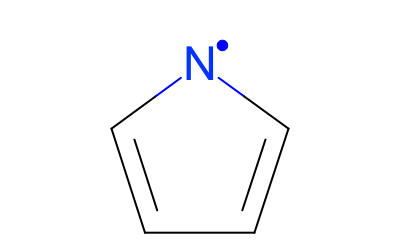
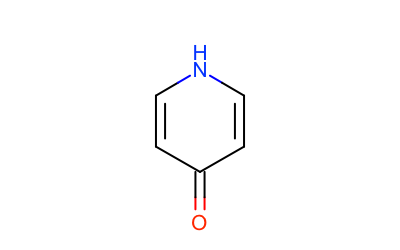
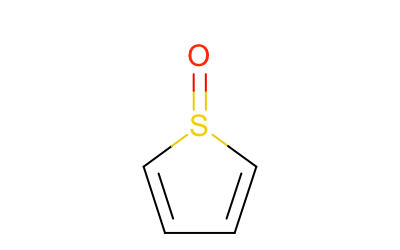
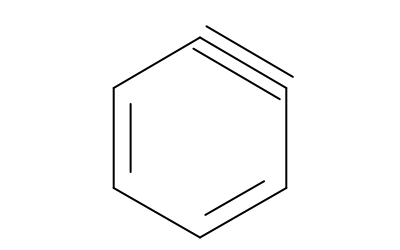
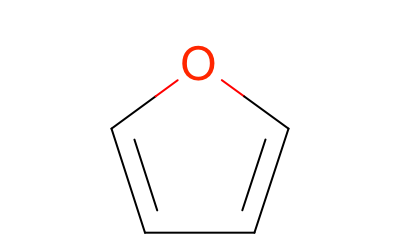
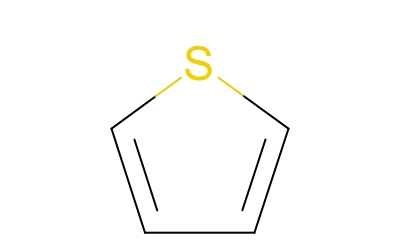
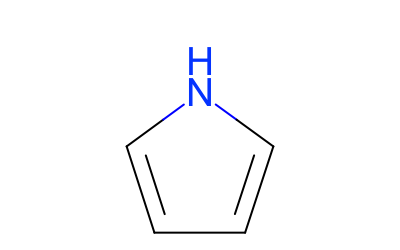
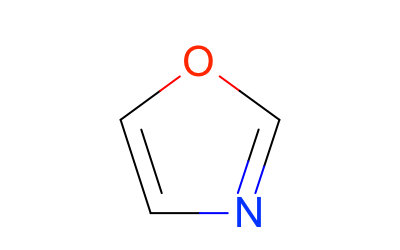
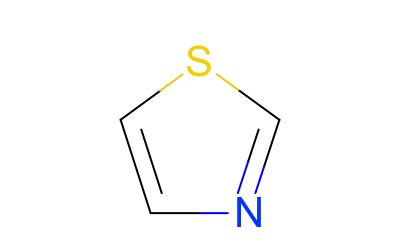
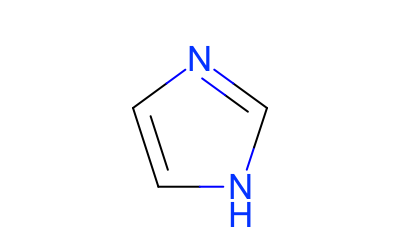
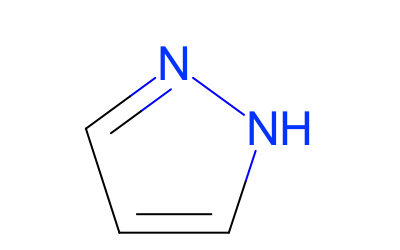
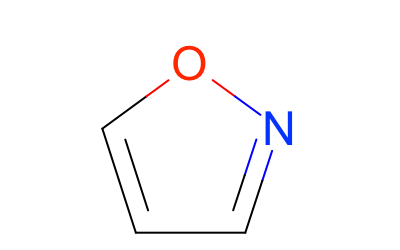
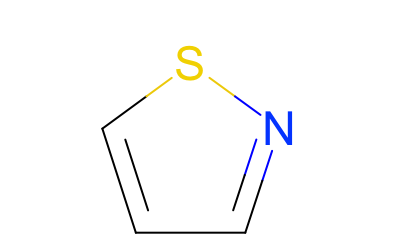
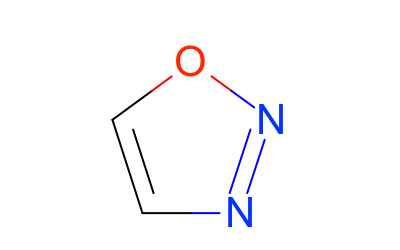
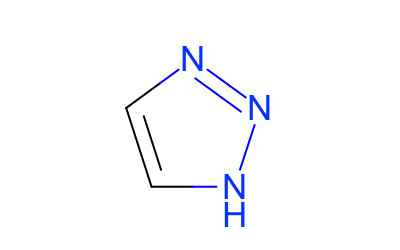
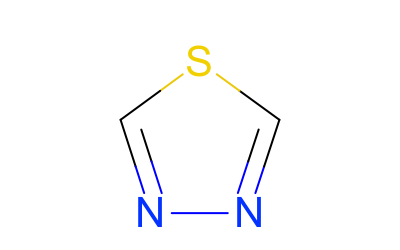
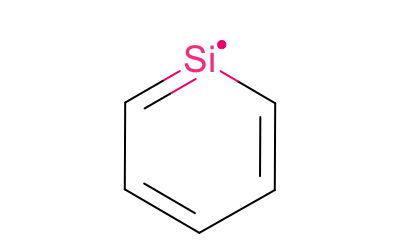
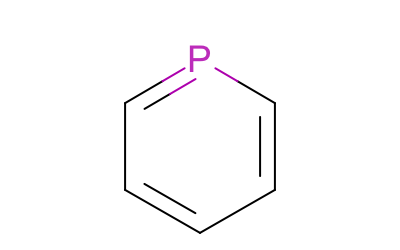
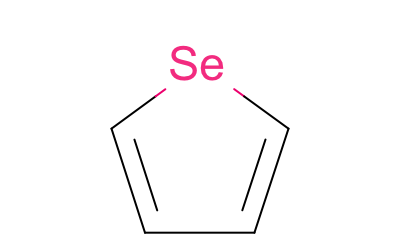
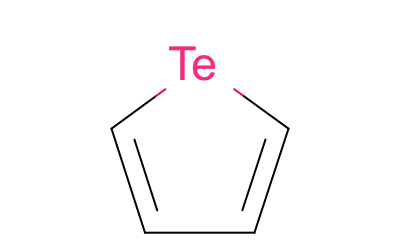

In [8]:
non_aromatic = [
    "C1=C[N]C=C1",    # radicals are not two electron donors
    "O=C1C=CNC=C1",   # exocyclic double bonds don't steal electrons
    "C1=CS(=O)C=C1",  # not sure how to classify this example from the
                        # OEChem docs
    "C1#CC=CC=C1",     # benzyne
    # 5-membered heterocycles
    "C1=COC=C1",           # furan
    "C1=CSC=C1",           # thiophene
    "C1=CNC=C1",        #pyrrole
    "C1=COC=N1",  # oxazole
    "C1=CSC=N1",  # thiazole
    "C1=CNC=N1",  # imidzole
    "C1=CNN=C1",  # pyrazole
    "C1=CON=C1",  # isoxazole
    "C1=CSN=C1",  # isothiazole
    "C1=CON=N1",  # 1,2,3-oxadiazole
    "C1=CNN=N1",  # 1,2,3-triazole
    "N1=CSC=N1",   # 1,3,4-thiadiazole
    # not outside the second rows 
    "C1=CC=C[Si]=C1", 
    "C1=CC=CC=P1", 
    # 5-membered heterocycles outside the second row
    "C1=C[Se]C=C1", 
    'C1=C[Te]C=C1',
         ]
df = make_dataframe_from_smiles(non_aromatic)
oenb.render_dataframe(df, render_func=lambda x, width, height: depict_aromatics(x, width=width, height=height))

These are systems we expected to be aromatic

,smiles,Molecule,is_aromatic
0,C1=CC=CC=C1,,True
1,N1=CC=CC=C1,,True
2,N1=CC=CC=N1,,True
3,N1=CC=CN=C1,,True
4,N1=CC=NC=C1,,True
5,N1=CN=CN=C1,,True
6,C1=CC2=CC=CC=CC2=C1,,True
7,C1=CC=CC2=CC=CC=C12,,True
8,C1=CC2=CC=CC=CC=C12,,True
9,C1=CC=C2C(=C1)N=CC=N2,,True

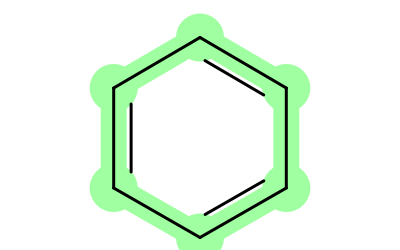
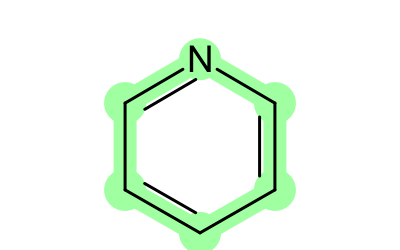
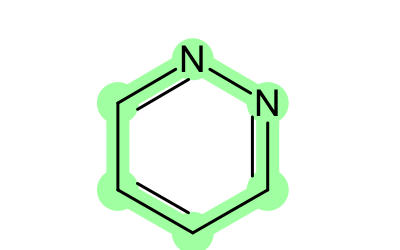
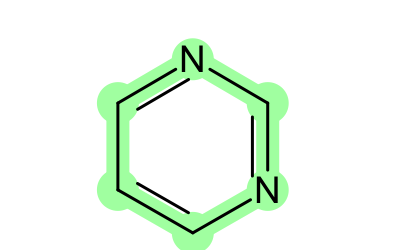
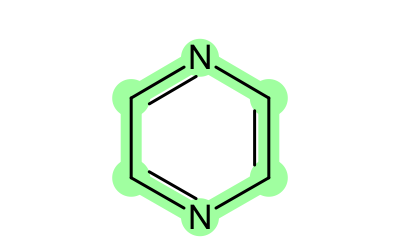
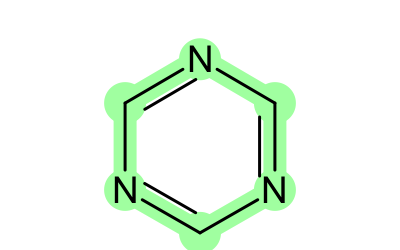
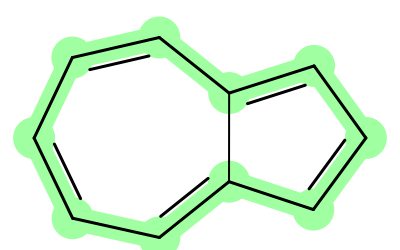
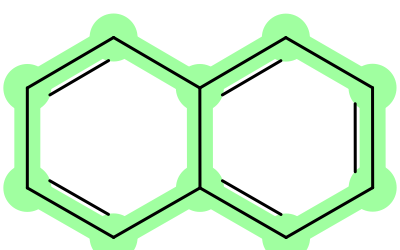
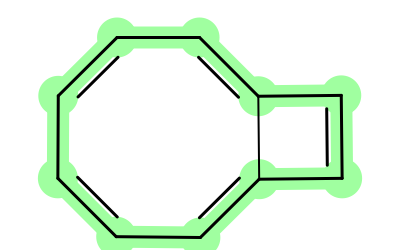
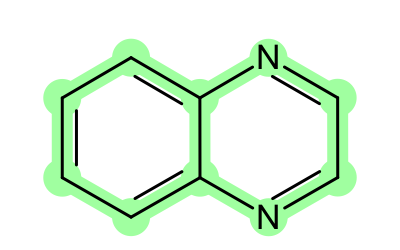
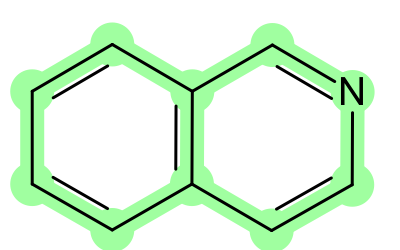
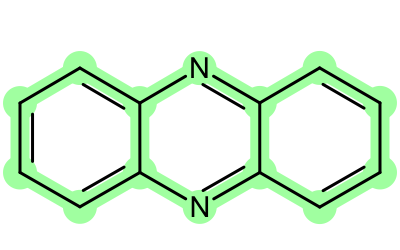
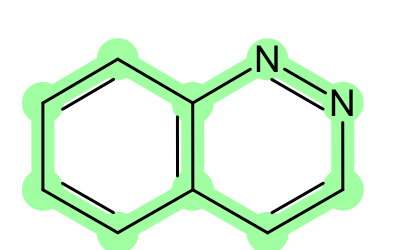
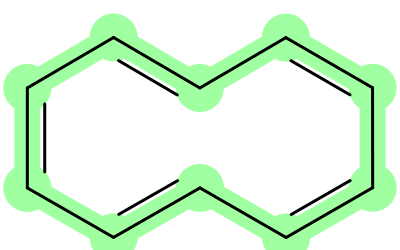
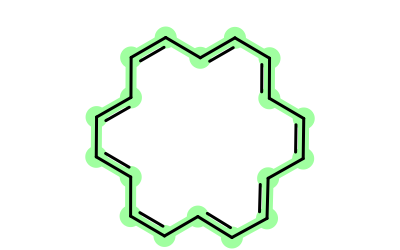
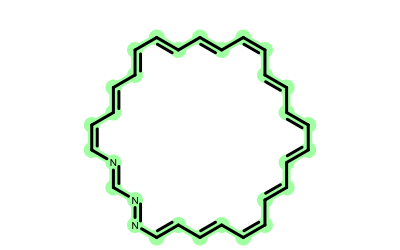

In [9]:
aromatic = [
    "C1=CC=CC=C1",         # benzene, of course
    # hetrocyclics
    "N1=CC=CC=C1",          # pyridine
    "N1=CC=CC=N1",   # pyridazine
    "N1=CC=CN=C1",   # pyrimidine
    "N1=CC=NC=C1",   # pyrazine
    "N1=CN=CN=C1",   # 1,3,5-triazine
    # polycyclic aromatics
    "C1=CC2=CC=CC=CC2=C1",  # azulene
    "C1=CC=CC2=CC=CC=C12",
    "C1=CC2=CC=CC=CC=C12",
    "C1=CC=C2C(=C1)N=CC=N2", 
    "C1=CN=CC2C=CC=CC1=2",
    "C1=CC=C2C(=C1)N=C3C=CC=CC3=N2",
    "C1=CN=NC2C=CC=CC1=2",
    # macrocycle aromatics
    "C1=CC=CC=CC=CC=C1",
    "C1=CC=CC=CC=CC=CC=CC=CC=CC=C1",
    "N1=CN=NC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1",
]
df = make_dataframe_from_smiles(aromatic)
oenb.render_dataframe(df, render_func=lambda x, width, height: depict_aromatics(x, width=width, height=height))

In this set we expected only some of the rings to be aromatic

,smiles,Molecule,is_aromatic
0,C1=CC=C2C(=C1)NC3=CC=CC=C32,,True
1,C1=CNC2C=CC=CC1=2,,True
2,C1=COC2C=CC=CC1=2,,True
3,C1=CSC2C=CC=CC1=2,,True
4,N1=CNC2N=CN=CC1=2,,True
5,N1=CNC2C=CC=CC1=2,,True

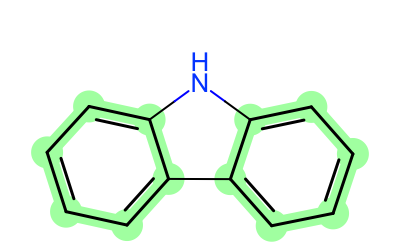
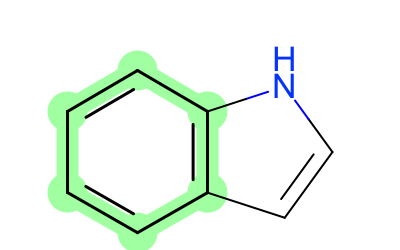
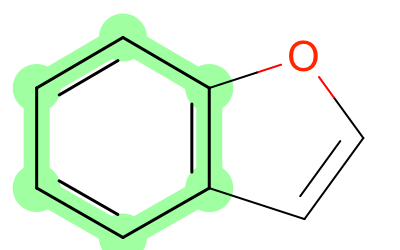
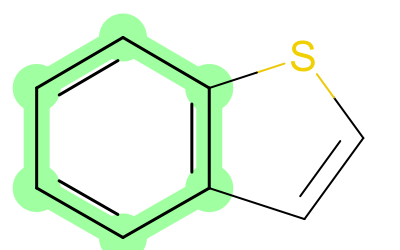
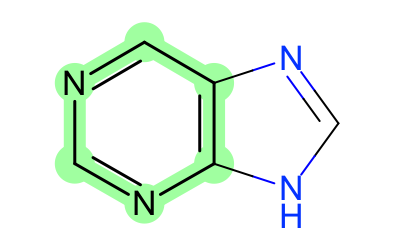
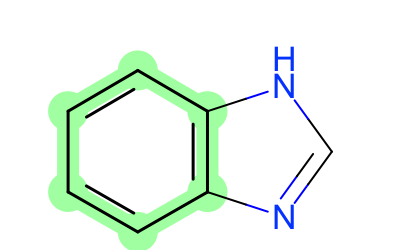

In [10]:
half_aromatic = ["C1=CC=C2C(=C1)NC3=CC=CC=C32", 
                 "C1=CNC2C=CC=CC1=2", 
                 "C1=COC2C=CC=CC1=2", 
                 "C1=CSC2C=CC=CC1=2", 
                 "N1=CNC2N=CN=CC1=2", 
                 "N1=CNC2C=CC=CC1=2", ]
df = make_dataframe_from_smiles(half_aromatic)
oenb.render_dataframe(df, render_func=lambda x, width, height: depict_aromatics(x, width=width, height=height))


Observing how polycyclic systems are or are not detected as aromatic

,smiles,Molecule,is_aromatic
0,C1=CC1=C,,False
1,C12=NC3=CCCCC3=CC2=CCCC1,,True
2,C1(=CC)C=CC(=CC)C=C1,,False
3,C1=CC2=CCCCC2=CC1=C,,False
4,C12=CC3=CCCC3=CC2=CCC1,,True
5,C12=CC3=CCCCCCCCC3=CC2=CCCCCCCC1,,True
6,C12=CC3=CC3=CC2=C1,,True
7,C12=CC3=CCCCC3=CC2=CCCC1,,True
8,C1(=C)C=CC(=C)C=C1,,False

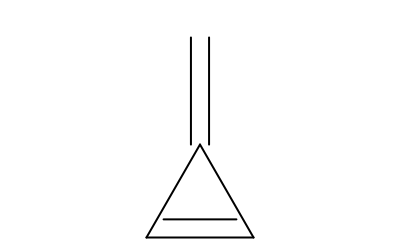
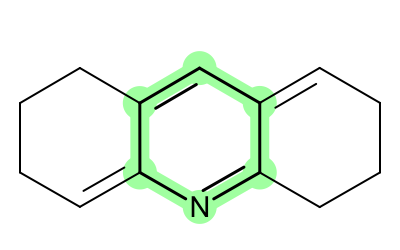
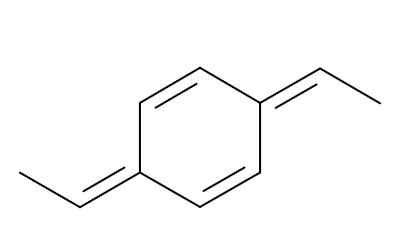
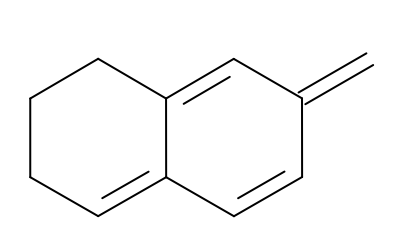
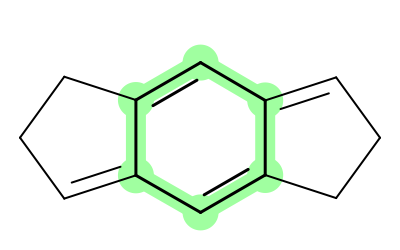
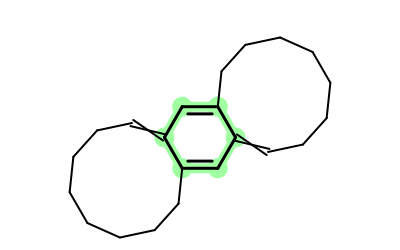
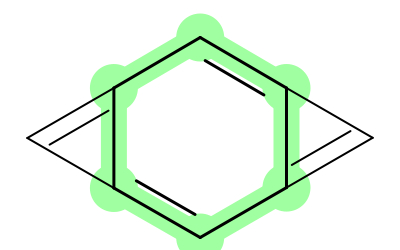
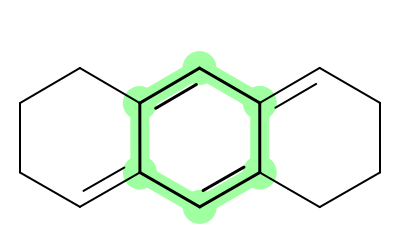
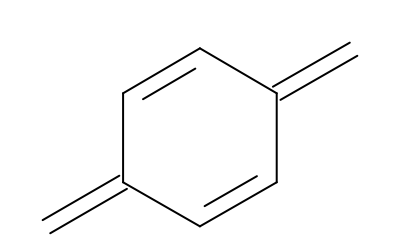

In [11]:
bridging = [ "C1=CC1=C",
"C12=NC3=CCCCC3=CC2=CCCC1", "C1(=CC)C=CC(=CC)C=C1",
    "C1=CC2=CCCCC2=CC1=C", "C12=CC3=CCCC3=CC2=CCC1", "C12=CC3=CCCCCCCCC3=CC2=CCCCCCCC1", "C12=CC3=CC3=CC2=C1", 
    "C12=CC3=CCCCC3=CC2=CCCC1", "C1(=C)C=CC(=C)C=C1"
]
df = make_dataframe_from_smiles(bridging)
oenb.render_dataframe(df, render_func=lambda x, width, height: depict_aromatics(x, width=width, height=height))

I wanted to test if there was a size limit on the aromaticity model.

,smiles,Molecule,is_aromatic
0,C1=CC=CC=CC=CC=C1,,True
1,C1=CC=CC=CC=CC=N1,,True
2,C1=CC=CC=CC=CC=CC=CC=C1,,True
3,C1=CC=CC=CC=CC=CC=CC=CC=CC=C1,,True
4,C1=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1,,True
5,C1=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1,,True
6,C1=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1,,True
7,N1=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1,,True
8,N1=CN=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1,,True
9,N1=CN=NC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1,,True

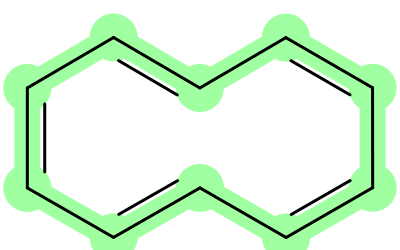
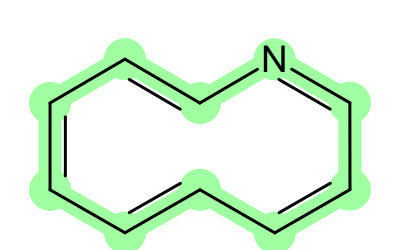
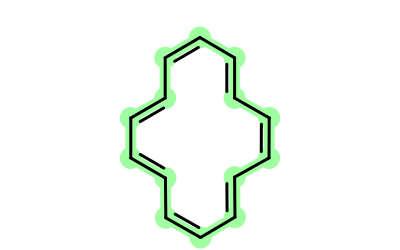
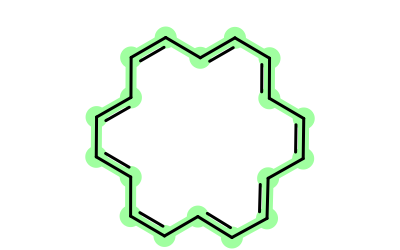
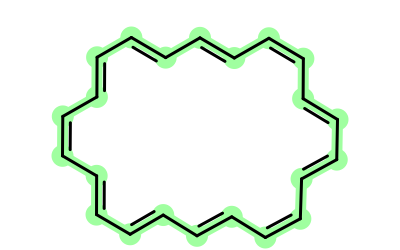
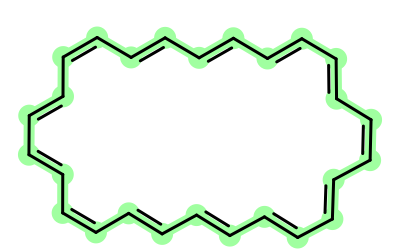
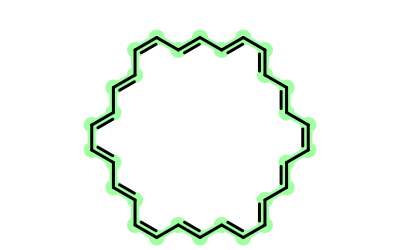
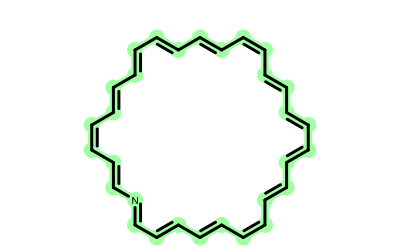
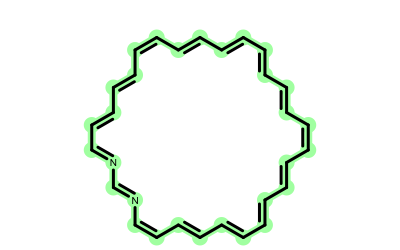
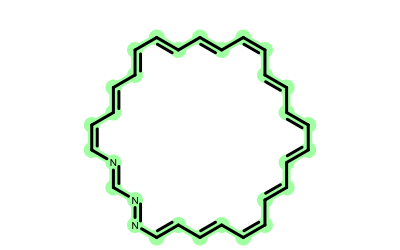

In [12]:
sizes = [
    "C1=CC=CC=CC=CC=C1",
    "C1=CC=CC=CC=CC=N1",
    #"C1=CC=CC=CC=CC=CC=C1",
    "C1=CC=CC=CC=CC=CC=CC=C1",
    #"C1=CC=CC=CC=CC=CC=CC=CC=C1",
    "C1=CC=CC=CC=CC=CC=CC=CC=CC=C1",
    #"C1=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1",
    "C1=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1",
    #"C1=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1",
    "C1=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1",
    #"C1=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1",
    "C1=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1",
    "N1=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1",
    "N1=CN=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1",
    "N1=CN=NC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C1",
]
df = make_dataframe_from_smiles(sizes)
oenb.render_dataframe(df, render_func=lambda x, width, height: depict_aromatics(x, width=width, height=height))

,smiles,Molecule,is_aromatic
0,CCc1c(c2cc3nc(cc4c(c(c([nH]4)cc5nc(cc1n2C)C(=C5CC)C)C)CCC(=O)O)C(=C3C)CCC(=O)O)C,,True

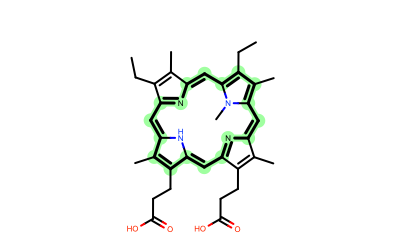

In [13]:
porphyrins = [
    "CCc1c(c2cc3nc(cc4c(c(c([nH]4)cc5nc(cc1n2C)C(=C5CC)C)C)CCC(=O)O)C(=C3C)CCC(=O)O)C"
]
df = make_dataframe_from_smiles(porphyrins)
oenb.render_dataframe(df, render_func=lambda x, width, height: depict_aromatics(x, width=width, height=height))

Greg Landrum from RDKit provided this list while trying to include this aromaticity model in their package

,smiles,Molecule,is_aromatic
0,C=C1C=CC(=C)C=C1,,False
1,O=C1C=CC(=O)C=C1,,False
2,O=C1C=CC=CC=C1,,False
3,C=C1C=CC=CC=C1,,False
4,C1=CC=CC=*1,,False
5,C1=CC=CC=B1,,False

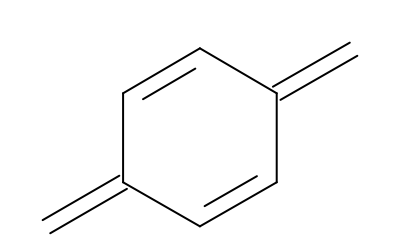
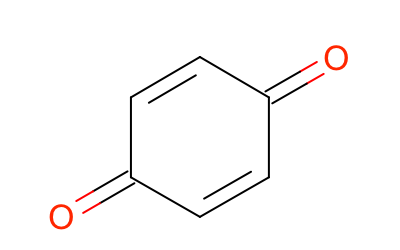
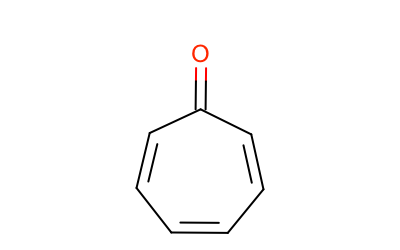
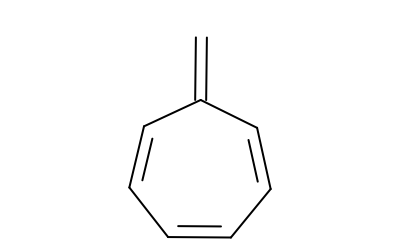
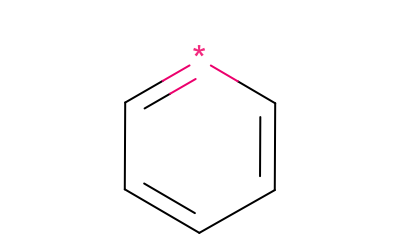
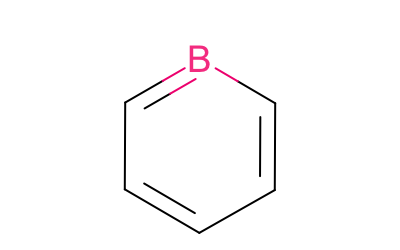

In [14]:
g_tests = ["C=C1C=CC(=C)C=C1", #   (are exocyclic double bonds allowed?)
"O=C1C=CC(=O)C=C1",  # (do exocyclic double bonds to electronegative atoms "steal" electrons?)
"O=C1C=CC=CC=C1", # (do exocyclic double bonds to electronegative atoms "steal" electrons?)
"C=C1C=CC=CC=C1",
           #"C1C=CC=C*1",  # (that's a dummy atom, I'm including it for the sake of completeness)
"C1=CC=CC=*1",
"C1=CC=CC=B1",  # (how is boron handled?)
          ]
df = make_dataframe_from_smiles(g_tests)
oenb.render_dataframe(df, render_func=lambda x, width, height: depict_aromatics(x, width=width, height=height))